### Alternating least squares

Let $A = A(i, j, k) \in \mathbb{R}^{n_1 \times n_2 \times n_3}$ be 3-dimensional tensor; its CP decomposition of rank $r$:

$$ A(i, j, k) = \sum_{\alpha=1}^{r} u_{\alpha}(i) v_{\alpha}(j) w_{\alpha}(k). $$

Coefficients $u_{\alpha}(i)$, $v_{\alpha}(j)$, $w_{\alpha}(k)$ form matrices $U \in \mathbb{R}^{n_1 \times r}$, $V \in \mathbb{R}^{n_2 \times r}$, $W \in \mathbb{R}^{n_3 \times r}$.

Alternating least squares algorithm for CP decomposition of rank $r$:
1. Initialize $U$, $V$, $W$ with random values.
2. Compute current tensor approximation $\tilde{A}(i, j, k) = \sum_{\alpha=1}^{r} u_{\alpha}(i) v_{\alpha}(j) w_{\alpha}(k)$
3. While $||A - \tilde{A}||_F < \varepsilon_2$ or $||U_{new} - U||_F + ||V_{new} - V||_F + ||W_{new} - W||_F < \varepsilon_2$:
   1. Fix $\tilde{v}_{\alpha}(j)$, $\tilde{w}_{\alpha}(k)$ and solve least squares problem $||A(i, j, k) - \sum_{\alpha=1}^{r} u_{\alpha}(i) \tilde{v}_{\alpha}(j) \tilde{w}_{\alpha}(k)||_F \to \min\limits_{u_{\alpha}(i)}$.
   2. The least-squares problem is equivalent to solving the following linear system:
      $$ \underbrace{\begin{bmatrix}          A(1, 1, 1) \\          \vdots \\          A(1, 1, n_3) \\          A(1, 2, 1) \\          \vdots \\          A(1, n_2, n_3) \\          A(2, 1, 1) \\          \vdots \\          A(2, n_2, n_3) \\          \vdots \\          \end{bmatrix}}_{\bar{A}} =                  \underbrace{\begin{bmatrix}             v_1(1)w_1(1) & 0 & 0 & \cdots \\             \vdots & \vdots & \vdots & \cdots \\             v_1(1)w_1(n_3) & \vdots & \vdots & \cdots \\             v_1(2)w_1(1) & \vdots & \vdots & \cdots \\             \vdots & \vdots & \vdots & \cdots \\             v_1(n_2)w_1(n_3) & \vdots & \vdots & \cdots \\             0 & v_1(1)w_1(1) & \vdots & \cdots \\             \vdots & \vdots & \vdots & \cdots \\             0 & v_1(n_2)w_1(n_3) & 0 & \cdots \\             \vdots & \vdots & \vdots & \cdots \\          \end{bmatrix}}_{H_u}           \underbrace{\begin{bmatrix}          u_1(1) \\          u_1(2) \\          \vdots \\          u_1(n_1) \\          u_2(1) \\          \vdots          \end{bmatrix}}_{\bar{U}},       $$
      where $\bar{A} \in \mathbb{R}^{n_1 \times n_2 \times n_3}$, $\bar{U} \in \mathbb{R}^{n_1 \times r}$ are the flattened copies of $A$ and $U$ respectively.
   3. Perform the same procedure for $v_{\alpha}(j)$ and $u_{\alpha}(k)$.

Below, there is a generalized version of the ALS algorithm for CP decomposition of $n$-dimensional tensors.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorly as tl
from tensorly.decomposition import parafac

import itertools
import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(suppress=True)

In [2]:
def cp_reconstruct(factors):
    # reconstruct tensor from CP-decomposition
    def check_shape(factors):
        it = iter(factors)
        first = next(it, None)
        return all(f.ndim == 2 and f.shape[1] == first.shape[1] for f in it)
        
    assert check_shape(factors), "Some of the factors shape or dimensionality is wrong"
    rank = factors[0].shape[1]
    tensor_dim = len(factors)

    A = np.zeros(tuple(f.shape[0] for f in factors))
    for j_rk in range(rank):
        outer_product = factors[0][:, j_rk]
        for i in range(1, tensor_dim):
            outer_product = np.outer(outer_product, factors[i][:, j_rk])
        A += outer_product.reshape(tuple(f.shape[0] for f in factors))
    return A

def random_tensor(ndim=None, shape=None, seed=None, ndim_bounds=(2, 5), shape_bounds=(1, 10), values_bounds=(0, 10)):
    if seed:
        np.random.seed(seed)
    if not ndim:
        ndim = np.random.randint(ndim_bounds[0], ndim_bounds[1], 1)
    if not shape:
        shape = np.random.randint(shape_bounds[0], shape_bounds[1], ndim)
    return np.random.uniform(values_bounds[0], values_bounds[1], shape)

def reorder_rhs(rhs, tensor_shape, fixed_var):
    # reorder rhs in linear system accordingly to a fixed variable
    assert len(rhs) == np.prod(tensor_shape), "Vector and tensor shapes mismatch"

    dim = len(tensor_shape)
    assert 0 <= fixed_var <= dim - 1, f"Fixed variable index {fixed_var} out of bounds [0;{dim-1}]"
    
    tensor_axes = []
    for i in range(dim):
        tensor_axes.append([x for x in range(tensor_shape[i])])
    tensor_indices = [i for i in itertools.product(*tensor_axes)] # cartesian product of indices along every axis
    # sort tensor indices wrt to fixed variable, rearrange rhs values accordingly
    sorted_indices, sorted_rhs = zip(*sorted(zip(tensor_indices, rhs), key=lambda x: (x[0][fixed_var], *np.delete(x[0], fixed_var))))
    return sorted_indices, sorted_rhs

def generate_coefs(factors, j_rk, drop_var):
    tensor_dim = len(factors)
    flag = False
    for i in range(tensor_dim):
        if i == drop_var:
            continue
        if not flag:
            outer_product = factors[i][:, j_rk]
            flag = True
        else:
            outer_product = np.outer(outer_product, factors[i][:, j_rk])
    return outer_product.flatten()

In [3]:
a = np.expand_dims(np.array([1, 2, 3]), -1)
b = np.expand_dims(np.array([3, 4, 5]), -1)
c = np.expand_dims(np.array([5, 6, 7]), -1)

A = cp_reconstruct([a, b, c])
A

array([[[ 15.,  18.,  21.],
        [ 20.,  24.,  28.],
        [ 25.,  30.,  35.]],

       [[ 30.,  36.,  42.],
        [ 40.,  48.,  56.],
        [ 50.,  60.,  70.]],

       [[ 45.,  54.,  63.],
        [ 60.,  72.,  84.],
        [ 75.,  90., 105.]]])

In [4]:
rank = 2
tA = tl.tensor(A)
factors = parafac(tA, rank=rank)
A_approx = tl.cp_to_tensor(factors)
np.linalg.norm((A - A_approx).flatten()) / np.linalg.norm(A.flatten())

1.1724619245198416e-15

In [5]:
U = [np.ones((dim, rank)) for dim in A.shape]
U_prev = np.copy(U)
rhs_reordered_sets = [reorder_rhs(A.flatten(), A.shape, dim)[1] for dim in range(A.ndim)]

eps = 1e-6
loss_log = []

for i in range(1000):
    for dim in range(A.ndim):
        dim_len = U[dim].shape[0]
        rhs = rhs_reordered_sets[dim]
        coefs_arr = [generate_coefs(U, j_rk, dim) for j_rk in range(rank)]
        dims_product_len = coefs_arr[0].shape[0]
        assert len(rhs) == dims_product_len * dim_len, "Coefficients column and rhs shapes mismatch"

        H = np.zeros((len(rhs), dim_len*rank))
        for j_k in range(dim_len): #fill coefficients columns
            H[j_k*dims_product_len:(j_k+1)*dims_product_len, j_k:dim_len*rank:dim_len] = np.array(coefs_arr).T
        
        U_prev[dim] = U[dim]
        U[dim] = np.linalg.lstsq(H, rhs)[0].reshape(rank, dim_len).T

    A_err = np.linalg.norm((A - cp_reconstruct(U)).flatten()) / np.linalg.norm(A.flatten())
    loss_log.append(A_err)
    if A_err < eps:
        break
print(f"Iterations: {len(loss_log)}, final relative error: {loss_log[-1]}")

Iterations: 37, final relative error: 3.0415227099556675e-07


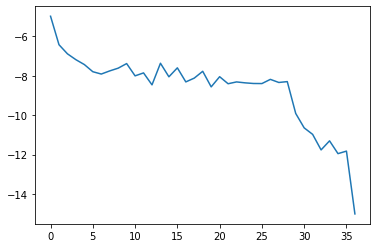

In [6]:
plt.plot(np.log(loss_log))